In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import os
import json
import tqdm
import matplotlib.ticker as ticker
sns.set()

In [2]:
import sys
sys.path.insert(0, '../')
from model.seq2seq import Seq2Seq, tf
from model.decoding_techniques import BeamSearchDecoder, GreedyDecoder, NucleusDecoder
from utils.processing_utils import *

1 Physical GPUs, 1 Logical GPUs


# Loading and preparation

In [3]:
data_path = '../processed_data'
mode = 'custom'
all_train = True
with open(os.path.join(data_path,'glove_embeddings_trained_opensubs.npy'), 'rb') as f:
        final_embeddings = np.load(f)
        
with open(os.path.join(data_path,'token_mapping_opensubs.json'), 'r') as f:
    token_mapping = json.load(f)

with open(os.path.join(data_path,'data_opensubs.npy'), 'rb') as f:
    data = np.load(f,allow_pickle=True) 
    
with open(os.path.join(data_path,'missing_in_glove_trained_opensubs.npy'), 'rb') as f:
        missing = np.load(f)

In [4]:
missing_idx = [token_mapping[i] for i in missing]

In [5]:
len(data)

1617140

In [6]:
inverse_token_mapping = dict((v,k) for k,v in token_mapping.items())
pad_token = inverse_token_mapping[0]
start_token = inverse_token_mapping[1]
end_token = inverse_token_mapping[2]
unk_token = inverse_token_mapping[3]

In [7]:
data = np.array(data)

In [8]:
X, y = data[:,0], data[:,1]

In [9]:
def map_to_ids(x, mapping, end_token=None, start_token=None, padding_token=None, max_len=None, 
              return_len=False):
  if isinstance(x, str):
    x = x.split(' ')
  max_len = max_len if max_len else len(x)
  length = len(x)
  if start_token:
    x = [start_token] + x
  sent_ids = [mapping[word] for word in x[:max_len]]
  if max_len>len(x):
      if end_token:
        sent_ids.append(mapping[end_token])
      if padding_token:
        sent_ids += [mapping[padding_token]]*(max_len-len(sent_ids))
      if return_len:
          return sent_ids,length+1
      else:
          return sent_ids
  if end_token:
    sent_ids[-1] = mapping[end_token]
  if return_len:
      return sent_ids, max_len
  else:
      return sent_ids


In [10]:
max_len_tokens = 10

In [11]:
if all_train:
    X_train_enc = np.array([map_to_ids(i, token_mapping, end_token, None, pad_token, max_len_tokens) for i in X])
    X_train_dec = np.array([map_to_ids(i, token_mapping, None, start_token, pad_token, max_len_tokens) for i in y])
    y_train, len_train = zip(*[map_to_ids(i, token_mapping, end_token, None, pad_token, max_len_tokens, return_len=True) for i in y])
    y_train, len_train = np.array(y_train), np.array(len_train)

In [12]:
X_train_dec[0], y_train[0], len_train[0]

(array([  1, 602,  14,   0,   0,   0,   0,   0,   0,   0]),
 array([602,  14,   2,   0,   0,   0,   0,   0,   0,   0]),
 3)

# Building a model

In [13]:
final_embeddings.shape

(50004, 100)

In [14]:
seq2seq = Seq2Seq(token_mapping, 
         pad_token=token_mapping[pad_token],
         end_token=token_mapping[end_token],
         start_token=token_mapping[start_token],
         max_len=max_len_tokens,
         embeddings=final_embeddings,
         embedding_prefix=mode,
         missing_tokens=np.array(missing_idx).astype(np.int32),
         dropout_prob=0.2,
        )

# Training a model 

In [15]:
train_data = tf.data.Dataset.from_tensor_slices((X_train_enc, X_train_dec, y_train, len_train))
if not all_train:
    val_data = tf.data.Dataset.from_tensor_slices((X_test_enc, X_test_dec, y_test, len_test))
else:
    val_data = None

In [16]:
batch_size = 256
num_epochs = 100
epochs_patience = 10

In [17]:
seq2seq.fit(train_data,
            validation_dataset=val_data,
            steps_per_epoch=X_train_enc.shape[0]//batch_size,
            batch_size=batch_size,
            num_epochs=num_epochs,
            epochs_patience=epochs_patience,
            experiment_name='opensubs')

Dir models already exists


  1%|          | 1/100 [23:19<38:29:52, 1399.93s/it]



Epoch 0 train loss 5.5081 train perplexity 771.9377


  2%|▏         | 2/100 [45:21<36:51:10, 1353.78s/it]



Epoch 1 train loss 4.9599 train perplexity 153.0233


  3%|▎         | 3/100 [1:07:30<36:10:03, 1342.31s/it]



Epoch 2 train loss 4.8124 train perplexity 131.3123


  4%|▍         | 4/100 [1:29:33<35:35:46, 1334.86s/it]



Epoch 3 train loss 4.7342 train perplexity 121.1666


  5%|▌         | 5/100 [1:51:35<35:06:24, 1330.37s/it]



Epoch 4 train loss 4.6772 train perplexity 114.2266


  6%|▌         | 6/100 [2:13:38<34:40:03, 1327.69s/it]



Epoch 5 train loss 4.6373 train perplexity 109.6827


  7%|▋         | 7/100 [2:35:41<34:15:24, 1326.06s/it]



Epoch 6 train loss 4.6056 train perplexity 106.1266


  8%|▊         | 8/100 [2:57:42<33:51:04, 1324.61s/it]



Epoch 7 train loss 4.5807 train perplexity 103.3711


  9%|▉         | 9/100 [3:19:43<33:27:27, 1323.60s/it]



Epoch 8 train loss 4.5593 train perplexity 101.2112


 10%|█         | 10/100 [3:41:45<33:04:13, 1322.82s/it]



Epoch 9 train loss 4.5414 train perplexity 99.3680


 11%|█         | 11/100 [4:03:48<32:42:14, 1322.86s/it]



Epoch 10 train loss 4.5257 train perplexity 97.7543


 12%|█▏        | 12/100 [4:25:49<32:19:36, 1322.45s/it]



Epoch 11 train loss 4.5111 train perplexity 96.2483


 13%|█▎        | 13/100 [4:47:52<31:57:52, 1322.67s/it]



Epoch 12 train loss 4.5011 train perplexity 95.3598


 14%|█▍        | 14/100 [5:09:51<31:34:04, 1321.44s/it]



Epoch 13 train loss 4.4904 train perplexity 94.3176


 15%|█▌        | 15/100 [5:31:50<31:10:53, 1320.63s/it]



Epoch 14 train loss 4.4827 train perplexity 93.5269


 16%|█▌        | 16/100 [5:53:55<30:50:56, 1322.10s/it]



Epoch 15 train loss 4.4725 train perplexity 92.5231


 17%|█▋        | 17/100 [6:15:58<30:29:08, 1322.27s/it]



Epoch 16 train loss 4.4652 train perplexity 91.8237


 18%|█▊        | 18/100 [6:37:59<30:06:43, 1322.00s/it]



Epoch 17 train loss 4.4566 train perplexity 91.0061


 19%|█▉        | 19/100 [6:59:58<29:43:32, 1321.14s/it]



Epoch 18 train loss 4.4529 train perplexity 90.6920


 20%|██        | 20/100 [7:22:02<29:22:22, 1321.78s/it]



Epoch 19 train loss 4.4466 train perplexity 90.1614


 21%|██        | 21/100 [7:44:09<29:02:45, 1323.61s/it]



Epoch 20 train loss 4.4415 train perplexity 89.6698


 22%|██▏       | 22/100 [8:06:21<28:43:49, 1326.01s/it]



Epoch 21 train loss 4.4359 train perplexity 89.0928


 23%|██▎       | 23/100 [8:28:22<28:19:36, 1324.37s/it]



Epoch 22 train loss 4.4334 train perplexity 88.9220


 24%|██▍       | 24/100 [8:50:24<27:56:50, 1323.82s/it]



Epoch 23 train loss 4.4293 train perplexity 88.5343


 25%|██▌       | 25/100 [9:12:29<27:35:10, 1324.14s/it]



Epoch 24 train loss 4.4244 train perplexity 88.0935


 26%|██▌       | 26/100 [9:34:35<27:13:51, 1324.75s/it]



Epoch 25 train loss 4.4216 train perplexity 87.7945


 27%|██▋       | 27/100 [9:56:41<26:52:21, 1325.22s/it]



Epoch 26 train loss 4.4166 train perplexity 87.3478


 28%|██▊       | 28/100 [10:18:49<26:31:01, 1325.85s/it]



Epoch 27 train loss 4.4141 train perplexity 87.1181


 29%|██▉       | 29/100 [10:40:57<26:09:38, 1326.45s/it]



Epoch 28 train loss 4.4125 train perplexity 87.0383


 30%|███       | 30/100 [11:03:03<25:47:27, 1326.39s/it]



Epoch 29 train loss 4.4071 train perplexity 86.5000


 31%|███       | 31/100 [11:25:12<25:26:25, 1327.33s/it]



Epoch 30 train loss 4.4078 train perplexity 86.6440


 32%|███▏      | 32/100 [11:48:00<25:17:49, 1339.26s/it]



Epoch 31 train loss 4.4043 train perplexity 86.3376


 33%|███▎      | 33/100 [12:10:06<24:51:23, 1335.57s/it]



Epoch 32 train loss 4.3999 train perplexity 85.8600


 34%|███▍      | 34/100 [12:32:08<24:24:33, 1331.41s/it]



Epoch 33 train loss 4.3998 train perplexity 85.8114


 35%|███▌      | 35/100 [12:54:10<23:59:12, 1328.50s/it]



Epoch 34 train loss 4.3980 train perplexity 85.7328


 36%|███▌      | 36/100 [13:16:15<23:36:05, 1327.58s/it]



Epoch 35 train loss 4.3945 train perplexity 85.3484


 37%|███▋      | 37/100 [13:38:23<23:14:07, 1327.74s/it]



Epoch 36 train loss 4.3919 train perplexity 85.1660


 38%|███▊      | 38/100 [14:00:24<22:49:37, 1325.45s/it]



Epoch 37 train loss 4.3924 train perplexity 85.2565


 39%|███▉      | 39/100 [14:22:23<22:25:47, 1323.73s/it]



Epoch 38 train loss 4.3879 train perplexity 84.8263


 40%|████      | 40/100 [14:44:23<22:02:31, 1322.52s/it]



Epoch 39 train loss 4.3880 train perplexity 84.7845


 41%|████      | 41/100 [15:06:23<21:39:39, 1321.69s/it]



Epoch 40 train loss 4.3864 train perplexity 84.6433


 42%|████▏     | 42/100 [15:28:23<21:17:06, 1321.16s/it]



Epoch 41 train loss 4.3829 train perplexity 84.4216


 43%|████▎     | 43/100 [15:50:21<20:54:24, 1320.42s/it]



Epoch 42 train loss 4.3825 train perplexity 84.3687


 44%|████▍     | 44/100 [16:12:20<20:31:54, 1319.90s/it]



Epoch 43 train loss 4.3814 train perplexity 84.3224


 45%|████▌     | 45/100 [16:34:19<20:09:35, 1319.56s/it]



Epoch 44 train loss 4.3812 train perplexity 84.2592


 46%|████▌     | 46/100 [16:56:19<19:47:43, 1319.70s/it]



Epoch 45 train loss 4.3803 train perplexity 84.2319


 47%|████▋     | 47/100 [17:18:15<19:24:51, 1318.72s/it]



Epoch 46 train loss 4.3775 train perplexity 83.9804


 48%|████▊     | 48/100 [17:40:12<19:02:16, 1318.01s/it]



Epoch 47 train loss 4.3769 train perplexity 83.9308


 49%|████▉     | 49/100 [18:02:08<18:39:52, 1317.51s/it]



Epoch 48 train loss 4.3756 train perplexity 83.7212


 50%|█████     | 50/100 [18:24:04<18:17:40, 1317.21s/it]



Epoch 49 train loss 4.3766 train perplexity 83.8667


 51%|█████     | 51/100 [18:46:01<17:55:32, 1316.98s/it]



Epoch 50 train loss 4.3742 train perplexity 83.6371


 52%|█████▏    | 52/100 [19:08:01<17:34:18, 1317.89s/it]



Epoch 51 train loss 4.3720 train perplexity 83.5031


 53%|█████▎    | 53/100 [19:30:01<17:12:48, 1318.48s/it]



Epoch 52 train loss 4.3725 train perplexity 83.5436


 54%|█████▍    | 54/100 [19:51:57<16:50:22, 1317.89s/it]



Epoch 53 train loss 4.3689 train perplexity 83.1413


 55%|█████▌    | 55/100 [20:13:54<16:28:08, 1317.51s/it]



Epoch 54 train loss 4.3702 train perplexity 83.3438


 56%|█████▌    | 56/100 [20:35:50<16:05:57, 1317.22s/it]



Epoch 55 train loss 4.3700 train perplexity 83.3369


 57%|█████▋    | 57/100 [20:57:47<15:43:52, 1317.03s/it]



Epoch 56 train loss 4.3690 train perplexity 83.2753


 58%|█████▊    | 58/100 [21:19:44<15:21:49, 1316.90s/it]



Epoch 57 train loss 4.3661 train perplexity 83.0013


 59%|█████▉    | 59/100 [21:41:40<14:59:49, 1316.82s/it]



Epoch 58 train loss 4.3667 train perplexity 83.0547


 60%|██████    | 60/100 [22:03:37<14:37:49, 1316.75s/it]



Epoch 59 train loss 4.3675 train perplexity 83.1528


 61%|██████    | 61/100 [22:25:36<14:16:19, 1317.43s/it]



Epoch 60 train loss 4.3651 train perplexity 82.8606


 62%|██████▏   | 62/100 [22:47:35<13:54:43, 1317.99s/it]



Epoch 61 train loss 4.3641 train perplexity 82.8172


 63%|██████▎   | 63/100 [23:09:34<13:32:55, 1318.26s/it]



Epoch 62 train loss 4.3638 train perplexity 82.8031


 64%|██████▍   | 64/100 [23:31:33<13:11:01, 1318.38s/it]



Epoch 63 train loss 4.3642 train perplexity 82.8095


 65%|██████▌   | 65/100 [23:54:59<13:04:27, 1344.79s/it]



Epoch 64 train loss 4.3626 train perplexity 82.6575


 66%|██████▌   | 66/100 [24:18:30<12:53:19, 1364.70s/it]



Epoch 65 train loss 4.3633 train perplexity 82.7608


 67%|██████▋   | 67/100 [24:41:05<12:28:59, 1361.80s/it]



Epoch 66 train loss 4.3610 train perplexity 82.5867


 68%|██████▊   | 68/100 [25:03:05<11:59:32, 1349.14s/it]



Epoch 67 train loss 4.3621 train perplexity 82.6101


 69%|██████▉   | 69/100 [25:25:04<11:32:28, 1340.26s/it]



Epoch 68 train loss 4.3594 train perplexity 82.2907


 70%|███████   | 70/100 [25:47:07<11:07:26, 1334.87s/it]



Epoch 69 train loss 4.3605 train perplexity 82.4947


 71%|███████   | 71/100 [26:09:09<10:43:21, 1331.09s/it]



Epoch 70 train loss 4.3574 train perplexity 82.3544


 72%|███████▏  | 72/100 [26:31:12<10:20:00, 1328.59s/it]



Epoch 71 train loss 4.3565 train perplexity 82.2022


 73%|███████▎  | 73/100 [26:53:15<9:57:06, 1326.89s/it] 



Epoch 72 train loss 4.3564 train perplexity 82.1306


 74%|███████▍  | 74/100 [27:15:19<9:34:36, 1326.03s/it]



Epoch 73 train loss 4.3585 train perplexity 82.4114


 75%|███████▌  | 75/100 [27:37:23<9:12:15, 1325.42s/it]



Epoch 74 train loss 4.3570 train perplexity 82.1968


 76%|███████▌  | 76/100 [27:59:26<8:49:52, 1324.68s/it]



Epoch 75 train loss 4.3577 train perplexity 82.2727


 77%|███████▋  | 77/100 [28:21:28<8:27:30, 1323.94s/it]



Epoch 76 train loss 4.3572 train perplexity 82.2571


 77%|███████▋  | 77/100 [28:22:42<8:28:36, 1326.78s/it]


KeyboardInterrupt: 

In [18]:
seq2seq.save_models(decoder_path='decoder_all_data_opensubs.h5',
                   encoder_path='encoder_all_data_opensubs.h5')

# Testing predictions and other helpful stuff

In [19]:
import sys
sys.path.insert(0, '../')
from utils.model_utils import plot_attention

In [20]:
def process(x, unk_token):
  res = []
  for i in x.split(' '):
    if token_mapping.get(i):
      res.append(i)
    elif token_mapping.get(i.lower()):
      res.append(i.lower())
    else:
      res.append(unk_token)
  return res

In [21]:
def give_answer(decoder, sentence, inverse_token_mapping, pad_unk=True, process_sentence=True, len_output=50,
               beam_size=3,
              top_p=0.95,
               beam_search=False,
               nucleus_sampling = False,
               show_attention=False):
      if process_sentence:
        cleaned_sentence = uncover_reduction(clean_bad_chars(sentence))
        unk_token = pad_token if pad_unk else "<unk>"
        processed_sentence = process(cleaned_sentence, unk_token)
        mapped_sentence = map_to_ids(processed_sentence, token_mapping, end_token, padding_token=pad_token, max_len=max_len_tokens)
      else:
        mapped_sentence = sentence
      if beam_search:
        prediction = decoder.decode(mapped_sentence, beam_size)
      elif nucleus_sampling:
        prediction = decoder.decode(mapped_sentence, len_output, top_p)
      else:
          prediction = decoder.decode(mapped_sentence, len_output, show_attention)
      if show_attention and not beam_search:
        prediction, attention = prediction
      answer = " ".join([inverse_token_mapping.get(i) for i in prediction]).capitalize()
      if show_attention and not beam_search:
            plot_attention(attention,sentence.split(' '), answer.split(' '))
      return answer

In [22]:
greedy_decoder = GreedyDecoder(decoder=seq2seq.decoder,
             encoder=seq2seq.encoder,
             max_len=max_len_tokens,
             start_token=token_mapping[start_token],
             end_token=token_mapping[end_token])

../utils/model_utils.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
../utils/model_utils.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


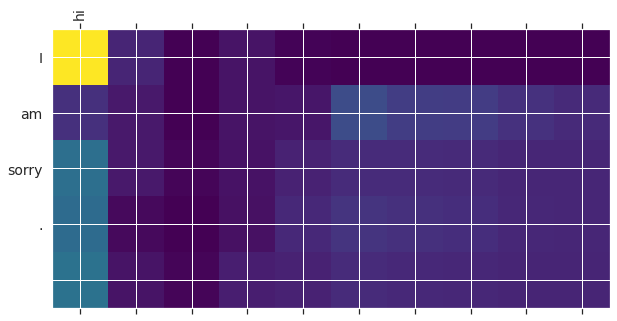

'I am sorry .'

In [23]:
give_answer(greedy_decoder, 'hi', inverse_token_mapping, show_attention=True)

In [24]:
beam_search_decoder = BeamSearchDecoder(decoder=seq2seq.decoder, 
                 encoder=seq2seq.encoder,
                 max_len=max_len_tokens,
                 start_token=token_mapping[start_token],
                 end_token=token_mapping[end_token])

In [25]:
give_answer(beam_search_decoder, 'hi ', inverse_token_mapping, show_attention=False,
           beam_search=True)

'Hi . hi .'

In [26]:
nucleus_decoder = NucleusDecoder(decoder=seq2seq.decoder, 
                 encoder=seq2seq.encoder,
                 max_len=max_len_tokens,
                 start_token=token_mapping[start_token],
                 end_token=token_mapping[end_token])

In [27]:
give_answer(nucleus_decoder, 'hi', inverse_token_mapping, nucleus_sampling=True, top_p=0.75)

'How about that story ?'

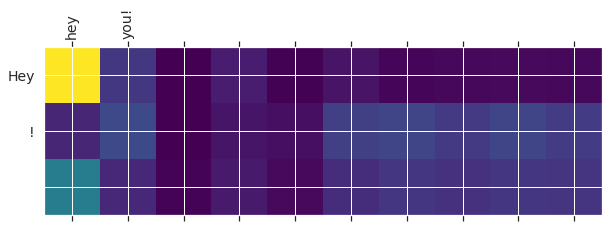

------------------------------
Test replica : hey you!
Bot greedy answer : Hey !
Bot beam search answer : Hey ! hey !
Bot nucleus answr : Now is in here just before it was long
------------------------------


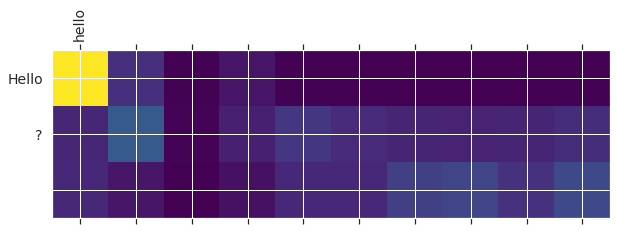

------------------------------
Test replica : hello
Bot greedy answer : Hello ?
Bot beam search answer : Hello ?
Bot nucleus answr : Where do you think this song music like that
------------------------------


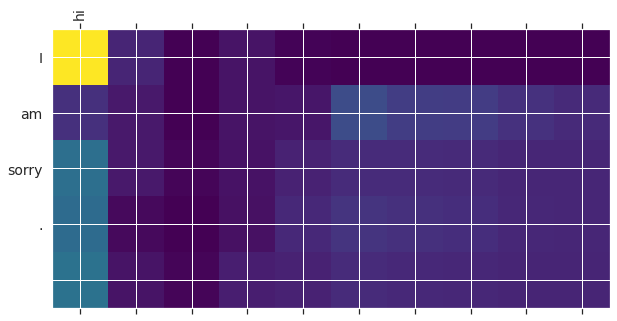

------------------------------
Test replica : hi
Bot greedy answer : I am sorry .
Bot beam search answer : Hi . hi .
Bot nucleus answr : And in your place all day up
------------------------------


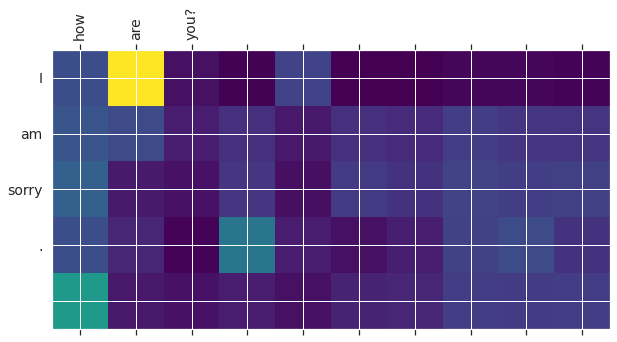

------------------------------
Test replica : how are you?
Bot greedy answer : I am sorry .
Bot beam search answer : Fine .
Bot nucleus answr : Iil be at there !
------------------------------


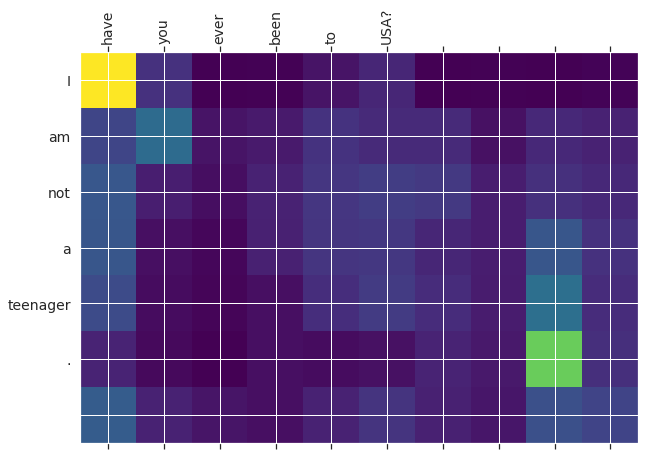

------------------------------
Test replica : have you ever been to USA?
Bot greedy answer : I am not a teenager .
Bot beam search answer : No .
Bot nucleus answr : Right there s over the big advantage .
------------------------------


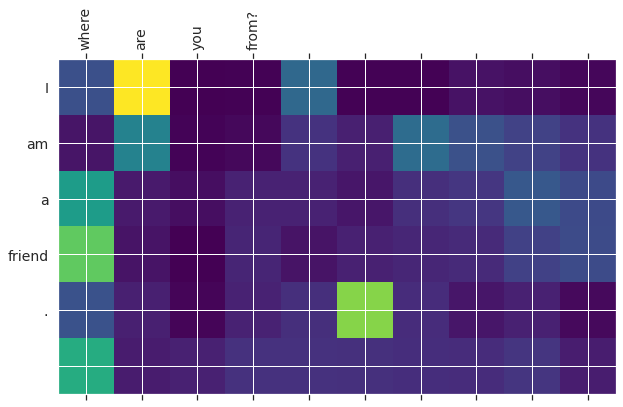

------------------------------
Test replica : where are you from?
Bot greedy answer : I am a friend .
Bot beam search answer : Boiro .
Bot nucleus answr : ( music )
------------------------------


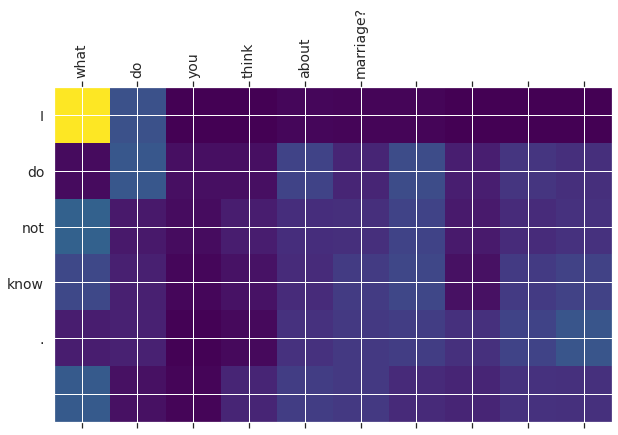

------------------------------
Test replica : what do you think about marriage?
Bot greedy answer : I do not know .
Bot beam search answer : I do not know .
Bot nucleus answr : So many your friends as stupid questions .
------------------------------


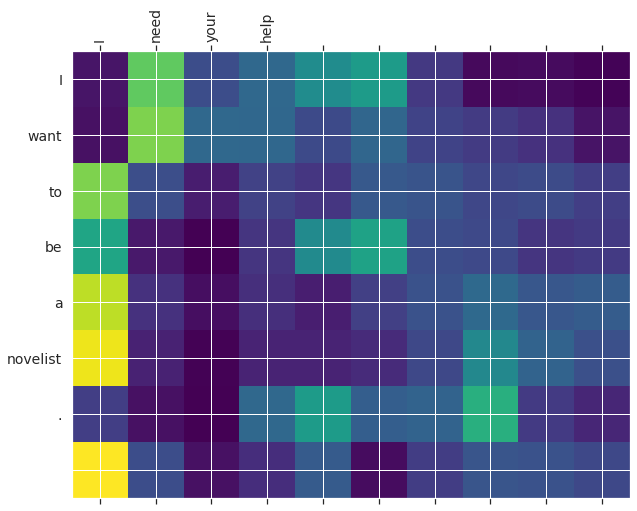

------------------------------
Test replica : I need your help
Bot greedy answer : I want to be a novelist .
Bot beam search answer : I want you to know
Bot nucleus answr : With my daughter in particular school student
------------------------------


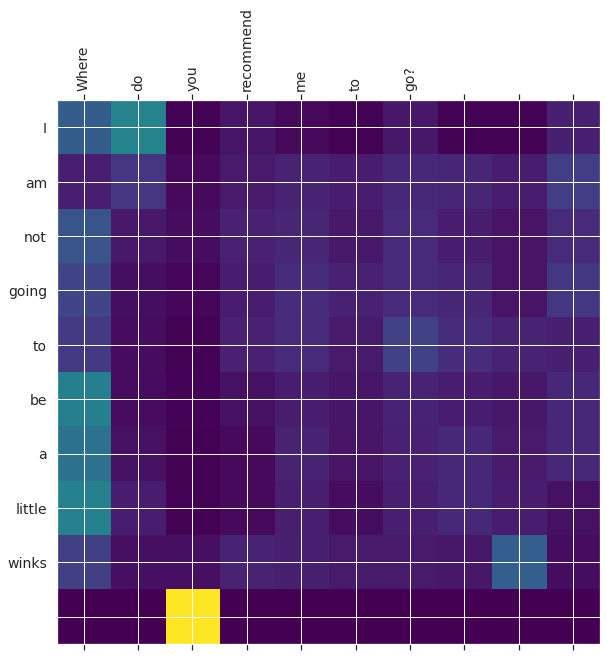

------------------------------
Test replica : Where do you recommend me to go?
Bot greedy answer : I am not going to be a little winks
Bot beam search answer : I do not know .
Bot nucleus answr : Not now
------------------------------


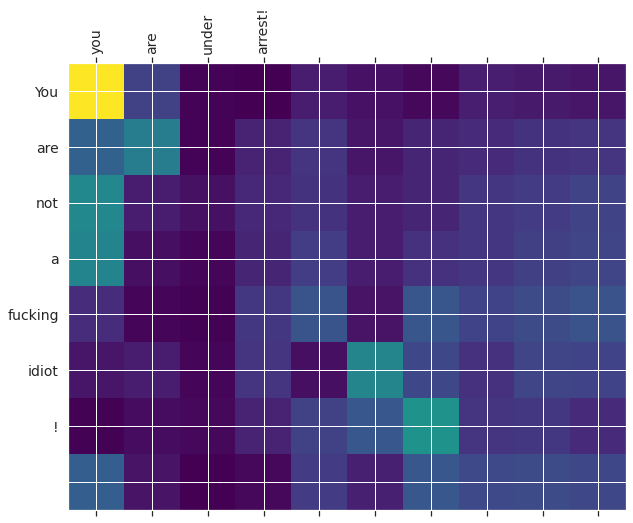

------------------------------
Test replica : you are under arrest!
Bot greedy answer : You are not a fucking idiot !
Bot beam search answer : What are you talking about ?
Bot nucleus answr : So just finish me up on that way of
------------------------------


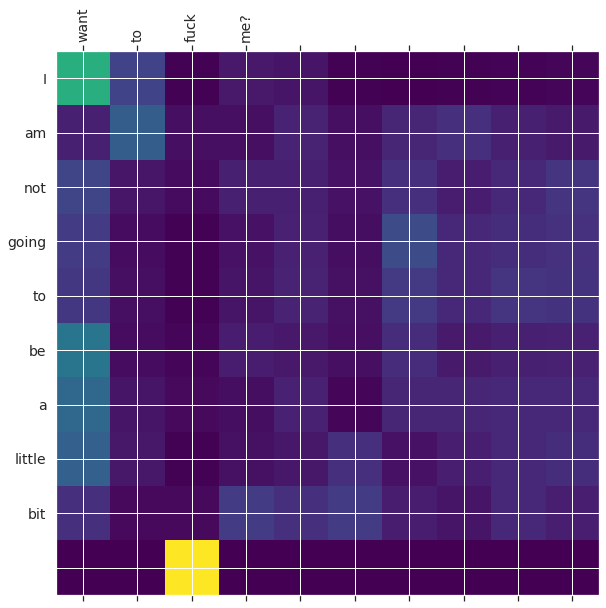

------------------------------
Test replica : want to fuck me?
Bot greedy answer : I am not going to be a little bit
Bot beam search answer : I do not know .
Bot nucleus answr : Excuse
------------------------------


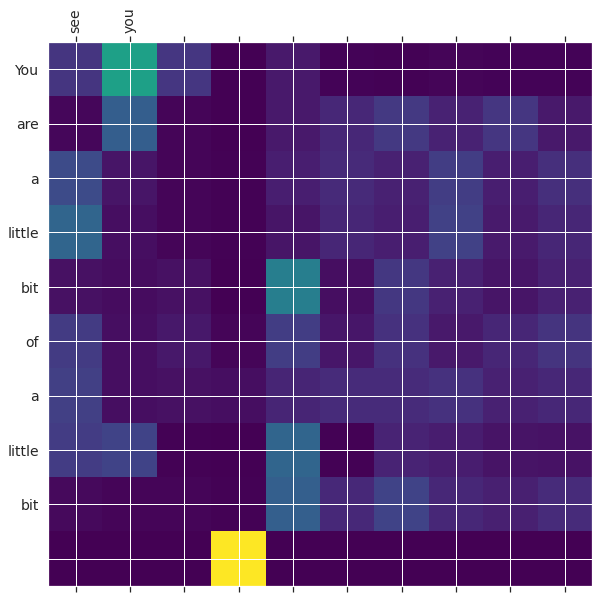

------------------------------
Test replica : see you
Bot greedy answer : You are a little bit of a little bit
Bot beam search answer : Oh
Bot nucleus answr : My you have found you in .
------------------------------


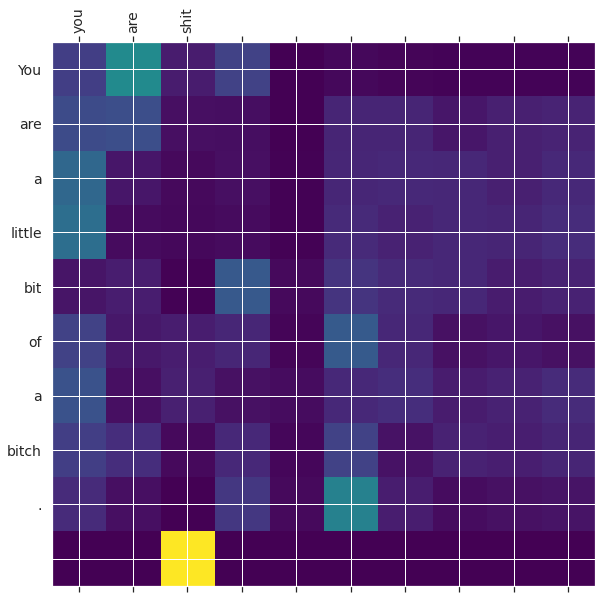

------------------------------
Test replica : you are shit
Bot greedy answer : You are a little bit of a bitch .
Bot beam search answer : I am gonna be over here .
Bot nucleus answr : Your dog the traings ai
------------------------------


In [28]:
replicas = ['hey you!',
            'hello',
            'hi',
            'how are you?',
            'have you ever been to USA?',
            'where are you from?',
            'what do you think about marriage?',
             'I need your help',
           'Where do you recommend me to go?',
           'you are under arrest!',
           'want to fuck me?',
           'see you',
           'you are shit']
for i in replicas:
    greedy_answer = give_answer(greedy_decoder, i, inverse_token_mapping, show_attention=True)
    beam_search_answer = give_answer(beam_search_decoder, i, inverse_token_mapping,
           beam_search=True,
           beam_size=3)
    nucleus_answer = give_answer(nucleus_decoder, i, inverse_token_mapping, 
                                 nucleus_sampling=True, 
                                 top_p=0.75)
    print(30*'-')
    print('Test replica : {}'.format(i))
    print('Bot greedy answer : {}'.format(greedy_answer))
    print('Bot beam search answer : {}'.format(beam_search_answer))
    print('Bot nucleus answr : {}'.format(nucleus_answer))
    print(30*'-')


# Gabberish dialogue

In [29]:
n_replicas = 100
count = 0
replica = str(input()).strip()
while count<n_replicas:
    replica = give_answer(nucleus_decoder, replica, inverse_token_mapping, 
                                 nucleus_sampling=True, 
                                 top_p=0.95)
    print('\n--- {}'.format(replica))
    count+=1

hi

--- Heilo cousin shoes could fall behind in many

--- Especially their toy service please emily when at lights

--- Ma les take louis fleet file works room have

--- Fatty p. and anybody sleeps it says place business

--- Pull overhead side chest gets laid from gibbons baby

--- Hiding there charlies also at which when this airport

--- Peter hill they really crack youn profits by sheep

--- Non jumping 4 degrees members u. body too woke

--- Yet along without peeling romance leads calls is penny

--- Mom brad open opening dreams live before this thursday

--- Lf . point next christmas eh ! get serious

--- Need facts money something scared has time ahead out

--- Lunch kate becky well new o base br food

--- Would you move alone but trooper i did really

--- More waste guilt side positive per seventh possibly do

--- Hi was murdered from tokyos heavy pharmaceutical record parties

--- Church dead roman products accountant orange vegas dealing ran

--- Familiar faces screaming blue

# Interactive usage

In [30]:
inp = ''
while True:
    inp = str(input()).strip()
    if inp=='exit':
        break
    greedy_answer = give_answer(greedy_decoder, inp, inverse_token_mapping, show_attention=False)
    beam_search_answer = give_answer(beam_search_decoder, inp, inverse_token_mapping,
           beam_search=True,
           beam_size=7)
    print(30*'-')
    print('Replica : {}'.format(inp))
    print('Beam answer : {}'.format(beam_search_answer))
    print('Greedy answer : {}'.format(greedy_answer))
    print(30*'-')

how old are you?
------------------------------
Replica : how old are you?
Beam answer : Eighteen .
Greedy answer : Eighteen .
------------------------------
what is your name?
------------------------------
Replica : what is your name?
Beam answer : Hi .
Greedy answer : I am sorry .
------------------------------
my name is John
------------------------------
Replica : my name is John
Beam answer : I do not know .
Greedy answer : I am a copilot
------------------------------
hey bro
------------------------------
Replica : hey bro
Beam answer : What are you talking about ?
Greedy answer : Hey hey hey hey hey hey hey hey hey
------------------------------
kill yourself
------------------------------
Replica : kill yourself
Beam answer : You
Greedy answer : You are not a coward .
------------------------------


KeyboardInterrupt: Interrupted by user